In [2]:
from Nb_utils import *

NOTE! Installing ujson may make loading annotations faster.


/home/superorange5/.local/lib/python3.8/site-packages/torchvision/transforms/transforms.py:803: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


# 1. select dataset

## 1a. CK2B

### load data

In [3]:
# parameter setting
ratio=1.2
dataset_name = 'VOC2007_bddval1'  
#dataset_name = 'VOC2007_bddvalsmall'
output_csv_file = 'eval_metric_ck2b.csv'
source_list =['kitti','cityscape']

# config
cfg = setup("configs/pt/final_c2b.yaml")

# load test data
test_data_loader = build_detection_test_loader(cfg, dataset_name)

# load annotations
data_annotation = DatasetCatalog.get(dataset_name)

# load model
#model_c2b = get_model('c2b', 11999)
#model_k2b = get_model('k2b', 'final')

model_c2b = get_model('c2b_source-only', 27999)
model_k2b = get_model('k2b_source-only', 7999)

model_list=[model_k2b,model_c2b]


keep_experiments/c2b_source-only/cfg.yaml
keep_experiments/c2b_source-only/model_0027999.pth
-------- pretrained model loaded ---------
-------- pretrained model loaded ---------
keep_experiments/k2b_source-only/cfg.yaml
keep_experiments/k2b_source-only/model_0007999.pth
-------- pretrained model loaded ---------
-------- pretrained model loaded ---------


## 1b. SKF2c

In [13]:
# parameter setting
dataset_name = 'VOC2007_cityval1'
source_list =['sim10k','kitti','foggycityscape']
output_csv_file = 'eval_metric_skf2c.csv'
ratio = 1.706
# config
cfg = setup("configs/pt/final_k2c.yaml")

test_data_loader = build_detection_test_loader(cfg, dataset_name)


#---------skf2c-------
#model_s2c = get_model('s2c', 15999)
#model_k2c = get_model('k2c', 19999)
#model_f2c = get_model('f2c', 'final') #8class
#model_f2c = get_model('f2c_1class', 11999)


model_s2c = get_model('s2c_source-only', 23999)
model_k2c = get_model('k2c_source-only', 'final')
model_f2c = get_model('f2c_source-only', 27999)

model_list=[model_s2c,model_k2c,model_f2c]

data_loader_iter = iter(test_data_loader)
test_data = data_loader_iter.next()
data_annotation = DatasetCatalog.get(dataset_name)


keep_experiments/s2c_source-only/cfg.yaml
keep_experiments/s2c_source-only/model_0023999.pth
-------- pretrained model loaded ---------
-------- pretrained model loaded ---------
keep_experiments/k2c_source-only/cfg.yaml
keep_experiments/k2c_source-only/model_final.pth
-------- pretrained model loaded ---------
-------- pretrained model loaded ---------
keep_experiments/f2c_source-only/cfg.yaml
keep_experiments/f2c_source-only/model_0027999.pth
-------- pretrained model loaded ---------
-------- pretrained model loaded ---------


# 4. Filter by others: (write car.txt)

* use 1 model as baseline to match others


In [302]:

#b1c66a42-6f7d68ca 0.971 933.1 339.5 1221.0 481.7
#output_folder = "tmp/skf2c_sim10k/"
#output_folder = "tmp/skf2c_kitti/"

#output_folder = "tmp/skf2c_foggy/"
output_folder = "tmp/ck2b_kitti_tmp/"
src_idx = 0

source_num = len(source_list)-1


if not os.path.exists(output_folder):
    os.makedirs( output_folder)
output_file = os.path.join(output_folder,"car.txt")

f = open(output_file, "w")


for i,test_data in enumerate(test_data_loader): 
    proposals_roih_multiple=[]
    for model in model_list:
        proposals_roih_multiple.append(get_proposal_roih(test_data,model))
    
    ma_gt, ma_src = get_match_array_all(proposals_roih_multiple, data_annotation[i]['annotations'],ratio)
    
    #------get keep index (all true)
    col_name = [ x for k,x in enumerate(source_list) if k!=src_idx]
    col_name.insert(0, 'groundtruth')
    df_src = pd.DataFrame()    
    src_array = np.array(ma_src[src_idx]).T
    df_src = pd.DataFrame(src_array, columns = col_name)
    df_src['summary'] = df_src.drop('groundtruth', axis=1).sum(axis=1)
    keep_index = df_src.index[df_src.summary==source_num]
            
    filename = os.path.basename(data_annotation[i]['file_name']).split('.')[0]
    
    for idx in keep_index:    
        bbox = proposals_roih_multiple[src_idx][0][idx].get('pred_boxes')
        score = proposals_roih_multiple[src_idx][0][idx].get('scores').cpu().numpy()[0]
        x1 = bbox.tensor[:, 0].cpu().numpy()[0]
        y1 = bbox.tensor[:, 1].cpu().numpy()[0]
        x2 = bbox.tensor[:, 2].cpu().numpy()[0]
        y2 = bbox.tensor[:, 3].cpu().numpy()[0]

        f.write("{} {:.3f} {:.1f} {:.1f} {:.1f} {:.1f}\n".format(filename,score,x1,y1,x2,y2))
f.close()

# 5. filter by score

In [226]:
len(test_data_loader)

5258

In [315]:
output_folder = "tmp/skf2c_threshold_foggy/"
model = model_f2c
threshold=0

if not os.path.exists(output_folder):
    os.makedirs( output_folder)
output_file = os.path.join(output_folder,"car.txt")

f = open(output_file, "w")


for i,test_data in enumerate(test_data_loader): 
    proposals_roih=get_proposal_roih(test_data,model)
    scaling(proposals_roih,ratio)
            
    filename = os.path.basename(data_annotation[i]['file_name']).split('.')[0]
    #print(len(proposals_roih[0]))
    
    
    confident_detections = proposals_roih[0][proposals_roih[0].scores > threshold]
    #print(len(confident_detections))
    #print(confident_detections)
    for bb_idx,bb in enumerate(confident_detections.pred_boxes):
        scores = confident_detections.scores.cpu().numpy()[bb_idx]    
        x1 = bb.cpu()[0].numpy()
        y1 = bb.cpu()[1].numpy()
        x2 = bb.cpu()[2].numpy()
        y2 = bb.cpu()[3].numpy()
        f.write("{} {:.3f} {:.1f} {:.1f} {:.1f} {:.1f}\n".format(filename,scores,x1,y1,x2,y2))
f.close()

In [309]:
data_loader_iter = iter(test_data_loader)
test_data = data_loader_iter.next()

proposals_roih = get_proposal_roih(test_data,model)
#scaling(proposals_roih,ratio)

In [313]:
proposals_roih[0].scores

tensor([0.9905, 0.9904, 0.9839, 0.9735, 0.9637, 0.9500, 0.9182, 0.9106, 0.8995,
        0.8882, 0.8751, 0.8206, 0.7514, 0.5427, 0.3144, 0.2696, 0.2413, 0.1475,
        0.1293, 0.1151, 0.0720, 0.0653, 0.0439, 0.0426, 0.0411, 0.0371, 0.0345,
        0.0259, 0.0230, 0.0145, 0.0120], device='cuda:0')

In [283]:
confident_detections = proposals_roih[0][proposals_roih[0].scores > 0.7]


In [289]:
len(proposals_roih[0])

59

In [282]:
proposals_roih[0].scores

tensor([0.8585, 0.8510, 0.2891, 0.2891, 0.2891, 0.2891, 0.0903, 0.0829, 0.0620,
        0.0594, 0.0484, 0.0395, 0.0394, 0.0359, 0.0327, 0.0289, 0.0283, 0.0253,
        0.0251, 0.0239, 0.0230, 0.0226, 0.0221, 0.0217, 0.0206, 0.0204, 0.0193,
        0.0177, 0.0176, 0.0175, 0.0171, 0.0170, 0.0170, 0.0169, 0.0165, 0.0159,
        0.0157, 0.0155, 0.0151, 0.0139, 0.0137, 0.0135, 0.0129, 0.0127, 0.0111,
        0.0103, 0.0102, 0.0102, 0.0091, 0.0079, 0.0073, 0.0058, 0.0057, 0.0057,
        0.0056, 0.0056, 0.0052, 0.0043, 0.0017], device='cuda:0')

In [247]:
confident_detections.scores.cpu().numpy()[10]

0.7825451

In [248]:
for bb_idx,bb in enumerate(confident_detections.pred_boxes):
        scores = confident_detections.scores.cpu().numpy()[bb_idx]    
        x1 = bb.cpu()[0].numpy()
        y1 = bb.cpu()[1].numpy()
        x2 = bb.cpu()[2].numpy()
        y2 = bb.cpu()[3].numpy()
        print("{} {:.3f} {:.1f} {:.1f} {:.1f} {:.1f}\n".format(filename,scores,x1,y1,x2,y2))

fe1f55fa-19ba3600 0.978 657.4 300.0 760.5 359.7

fe1f55fa-19ba3600 0.977 765.4 269.6 1029.1 405.8

fe1f55fa-19ba3600 0.953 621.5 301.7 683.1 345.3

fe1f55fa-19ba3600 0.943 17.7 287.6 113.3 337.8

fe1f55fa-19ba3600 0.913 498.6 296.3 530.5 319.8

fe1f55fa-19ba3600 0.905 608.3 306.9 643.7 338.6

fe1f55fa-19ba3600 0.902 569.7 301.1 601.7 328.6

fe1f55fa-19ba3600 0.901 735.1 310.4 828.6 379.4

fe1f55fa-19ba3600 0.899 202.1 288.5 295.7 333.0

fe1f55fa-19ba3600 0.849 3.5 283.0 52.4 341.3

fe1f55fa-19ba3600 0.783 169.4 282.3 237.7 322.0

fe1f55fa-19ba3600 0.752 585.2 306.9 622.1 333.7



In [185]:
threshold = 0.7

proposals_roih_multiple[0][0].scores

tensor([0.9708, 0.9707, 0.9612, 0.9462, 0.9312, 0.8988, 0.8963, 0.8774, 0.8749,
        0.8527, 0.7561, 0.7531, 0.6275, 0.5939, 0.5390, 0.4565, 0.4178, 0.2566,
        0.1998, 0.1848, 0.1812, 0.1348, 0.1121, 0.0759, 0.0390, 0.0331, 0.0330,
        0.0310, 0.0206, 0.0180, 0.0171, 0.0161, 0.0135, 0.0127, 0.0123, 0.0106,
        0.0099, 0.0094], device='cuda:0')

In [ ]:
for bb_idx in 

In [216]:
confident_detections = proposals_roih_multiple[0][0][proposals_roih_multiple[0][0].scores > 0.9]

In [222]:
confident_detections.scores

tensor([0.8585, 0.8510], device='cuda:0')

In [214]:
confident_detections

Instances(num_instances=5, image_height=600, image_width=1067, fields=[pred_boxes: Boxes(tensor([[ 776.9964,  282.1017, 1017.7812,  401.4134],
        [ 662.6821,  302.0353,  754.8343,  358.3494],
        [ 625.2906,  302.1401,  683.5735,  344.2126],
        [  32.3438,  291.6617,  106.5337,  333.4795],
        [ 734.6452,  314.2469,  805.8868,  373.9079]], device='cuda:0')), scores: tensor([0.9708, 0.9707, 0.9612, 0.9462, 0.9312], device='cuda:0'), pred_classes: tensor([0, 0, 0, 0, 0], device='cuda:0'), scores_logists: tensor([[ 3.3746, -3.4222],
        [ 3.0637, -3.1017],
        [ 3.7150, -3.7093],
        [ 3.2326, -3.2229],
        [ 2.6753, -2.6198]], device='cuda:0'), boxes_sigma: tensor([[-3.4894, -3.9871, -3.1702, -3.6849],
        [-3.6285, -3.7810, -3.3161, -3.6317],
        [-3.2193, -3.3684, -2.9709, -3.3978],
        [-2.8282, -3.2153, -2.5468, -3.1238],
        [-2.9457, -2.7821, -2.3568, -2.7212]], device='cuda:0')])

In [217]:
for bb in confident_detections.pred_boxes:
    scores = confident_detections.scores.cpu().numpy()[0]    
    x1 = bb.cpu()[0].numpy()
    y1 = bb.cpu()[1].numpy()
    x2 = bb.cpu()[2].numpy()
    y2 = bb.cpu()[3].numpy()
    print("{:.3f} {:.1f} {:.1f} {:.1f} {:.1f}".format(scores, x1,y1,x2,y2))

0.971 777.0 282.1 1017.8 401.4
0.971 662.7 302.0 754.8 358.3
0.971 625.3 302.1 683.6 344.2
0.971 32.3 291.7 106.5 333.5
0.971 734.6 314.2 805.9 373.9


# 2. Get results

## 2A.single image test

In [7]:
data_loader_iter = iter(test_data_loader)
test_data = data_loader_iter.next()

proposals_roih_multiple=[]
for model in model_list:
    proposals_roih_multiple.append(get_proposal_roih(test_data,model))

    #data_annotation[0]['annotations'][0]['bbox']
ma_gt, ma_src = get_match_array_all(proposals_roih_multiple, data_annotation[0]['annotations'],ratio)



In [10]:
data_annotation[0]['annotations']

[{'category_id': 0,
  'bbox': [206.0, 338.0, 283.0, 389.0],
  'bbox_mode': <BoxMode.XYXY_ABS: 0>},
 {'category_id': 0,
  'bbox': [47.0, 344.0, 131.0, 402.0],
  'bbox_mode': <BoxMode.XYXY_ABS: 0>},
 {'category_id': 0,
  'bbox': [247.0, 344.0, 348.0, 397.0],
  'bbox_mode': <BoxMode.XYXY_ABS: 0>},
 {'category_id': 0,
  'bbox': [0.0, 337.0, 53.0, 404.0],
  'bbox_mode': <BoxMode.XYXY_ABS: 0>},
 {'category_id': 0,
  'bbox': [684.0, 357.0, 722.0, 394.0],
  'bbox_mode': <BoxMode.XYXY_ABS: 0>},
 {'category_id': 0,
  'bbox': [706.0, 364.0, 735.0, 392.0],
  'bbox_mode': <BoxMode.XYXY_ABS: 0>},
 {'category_id': 0,
  'bbox': [727.0, 366.0, 762.0, 402.0],
  'bbox_mode': <BoxMode.XYXY_ABS: 0>},
 {'category_id': 0,
  'bbox': [749.0, 362.0, 810.0, 410.0],
  'bbox_mode': <BoxMode.XYXY_ABS: 0>},
 {'category_id': 0,
  'bbox': [787.0, 358.0, 907.0, 426.0],
  'bbox_mode': <BoxMode.XYXY_ABS: 0>},
 {'category_id': 0,
  'bbox': [880.0, 376.0, 961.0, 453.0],
  'bbox_mode': <BoxMode.XYXY_ABS: 0>},
 {'category_id

In [8]:
proposals_roih_multiple[0][0].get('scores')

tensor([0.7708, 0.7278, 0.6378, 0.6011, 0.5827, 0.5590, 0.5444, 0.4486, 0.3859,
        0.3571, 0.3526, 0.3247, 0.2898, 0.2826, 0.2621, 0.2517, 0.2437, 0.2108,
        0.1974, 0.1525, 0.1306, 0.1177, 0.0898, 0.0801, 0.0693, 0.0689, 0.0681,
        0.0661, 0.0654, 0.0533, 0.0498, 0.0495, 0.0362, 0.0293, 0.0262, 0.0259,
        0.0219, 0.0165, 0.0142, 0.0140, 0.0134, 0.0129, 0.0060, 0.0034, 0.0032],
       device='cuda:0')

In [9]:
proposals_roih_multiple[0][0].get('pred_boxes')

Boxes(tensor([[ 792.8904,  358.6422,  906.5364,  426.1711],
        [ 960.1653,  326.4732, 1218.6995,  487.6807],
        [   0.0000,  334.5512,   53.6761,  403.3617],
        [  30.9183,  346.8628,  127.1009,  395.6460],
        [ 597.4185,  350.7612,  633.2883,  383.2562],
        [ 745.7241,  362.6562,  820.6821,  410.0619],
        [ 225.0770,  345.6514,  342.5850,  415.3205],
        [ 880.3300,  373.2979, 1003.5423,  444.1038],
        [ 690.1130,  361.3881,  735.3576,  391.5140],
        [ 759.3828,  368.6732,  803.9904,  408.3677],
        [ 874.6600,  363.2095, 1082.3218,  455.0985],
        [ 727.7149,  365.1144,  785.9441,  402.7550],
        [  30.2677,  347.0260,   79.7104,  399.5431],
        [ 709.9203,  368.4640,  745.4404,  395.3076],
        [1278.8931,   84.0169, 1280.4000,  174.9864],
        [ 718.4980,  364.8721,  757.6174,  393.1482],
        [ 204.3775,  337.5041,  293.7446,  380.5070],
        [ 278.7805,  348.5946,  349.6636,  392.0493],
        [ 778.6660,  3

### get TP FP

In [17]:
TP, TN_array  =get_TP(ma_gt,source_list)
#TP, TN1, TN2
FP_array = get_FP(ma_src,source_list)
# src1 FP1 FP2, src2 FP1 FP2

In [18]:
TP

18

In [19]:
TN_array

[0, 0, 0]

In [20]:
FP_array

[[5, 13, 1], [1, 0, 1], [3, 5, 6]]

## 2.B output results of all images

### save to eval_metricxxx.csv

In [14]:
eval_metric_summary(test_data_loader, data_annotation,model_list, source_list,
                    output_file = output_csv_file,ratio=ratio)

# 3. draw pie chart

### a.ck2b

In [5]:
input_file = 'eval_metric_ck2b.csv'
title = 'ck2b'

### b.skf2c

In [15]:
input_file = 'eval_metric_skf2c.csv'
title = 'skf2c'

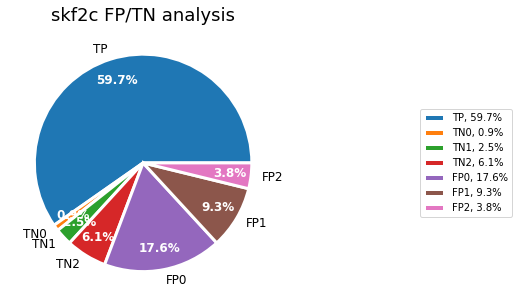

In [16]:

eval_skf2c = pd.read_csv(input_file)
labels = eval_skf2c.columns[1:]

pie_chart_list = gen_pie_chart_list(eval_skf2c)
draw_pie_chart(pie_chart_list, labels,title)

# 6. ensemble BBox

# Appendix. show match array 

### a. gt

In [10]:
df_gt = pd.DataFrame()

ma_gt_array = np.array(ma_gt).T
df_gt = pd.DataFrame(ma_gt_array, columns = source_list)
df_gt

,sim20k,kitti,foggycityscape
0,True,True,False
1,True,True,True
2,True,True,True
3,True,True,True
4,True,True,True
5,True,True,True
6,True,True,True
7,True,True,True
8,True,True,True
9,False,False,False


### b. source

In [6]:
#ma_src

df_src = pd.DataFrame()

ma_src_array = np.array(ma_src[2]).T
df_src = pd.DataFrame(ma_src_array, columns = source_list)
df_src.to_csv("src_foggy2city_match_array.csv")

In [45]:
TP

7

In [46]:
TN_array

[11, 1, 0]

In [47]:
FP_array

[[5, 13, 22], [1, 0, 24], [3, 5, 30]]